# Project 2: Topic Classification

In this project, you'll work with text data from newsgroup postings on a variety of topics. You'll train classifiers to distinguish between the topics based on the text of the posts. Whereas with digit classification, the input is relatively dense: a 28x28 matrix of pixels, many of which are non-zero, here we'll represent each document with a "bag-of-words" model. As you'll see, this makes the feature representation quite sparse -- only a few words of the total vocabulary are active in any given document. The bag-of-words assumption here is that the label depends only on the words; their order is not important.

The SK-learn documentation on feature extraction will prove useful:
http://scikit-learn.org/stable/modules/feature_extraction.html

Each problem can be addressed succinctly with the included packages -- please don't add any more. Grading will be based on writing clean, commented code, along with a few short answers.

As always, you're welcome to work on the project in groups and discuss ideas on the course wall, but please prepare your own write-up and write your own code.

In [42]:
# This tells matplotlib not to try opening a new window for each plot.
%matplotlib inline

# General libraries.
import re
import numpy as np
import matplotlib.pyplot as plt

# SK-learn libraries for learning.
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.grid_search import GridSearchCV

# SK-learn libraries for evaluation.
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import classification_report

# SK-learn library for importing the newsgroup data.
from sklearn.datasets import fetch_20newsgroups

# SK-learn libraries for feature extraction from text.
from sklearn.feature_extraction.text import *

Load the data, stripping out metadata so that we learn classifiers that only use textual features. By default, newsgroups data is split into train and test sets. We further split the test so we have a dev set. Note that we specify 4 categories to use for this project. If you remove the categories argument from the fetch function, you'll get all 20 categories.

In [43]:
categories = ['alt.atheism', 'talk.religion.misc', 'comp.graphics', 'sci.space']
newsgroups_train = fetch_20newsgroups(subset='train',
                                      remove=('headers', 'footers', 'quotes'),
                                      categories=categories)
newsgroups_test = fetch_20newsgroups(subset='test',
                                     remove=('headers', 'footers', 'quotes'),
                                     categories=categories)

num_test = len(newsgroups_test.target)
test_data, test_labels = newsgroups_test.data[num_test//2:], newsgroups_test.target[num_test//2:]
dev_data, dev_labels = newsgroups_test.data[:num_test//2], newsgroups_test.target[:num_test//2]
train_data, train_labels = newsgroups_train.data, newsgroups_train.target

print('training label shape:', train_labels.shape)
print('test label shape:', test_labels.shape)
print('dev label shape:', dev_labels.shape)
print('labels names:', newsgroups_train.target_names)

#print(train_data[:5])

training label shape: (2034,)
test label shape: (677,)
dev label shape: (676,)
labels names: ['alt.atheism', 'comp.graphics', 'sci.space', 'talk.religion.misc']


(1) For each of the first 5 training examples, print the text of the message along with the label.

In [44]:
def P1(num_examples=5):
### STUDENT START ###

    for number in range(num_examples):
        print("Example:", number + 1)
        print("Training Label:", train_labels[number], newsgroups_train.target_names[train_labels[number]])
        print("Training Text:", train_data[number], "\n")
        
### STUDENT END ###
P1()

Example: 1
Training Label: 1 comp.graphics
Training Text: Hi,

I've noticed that if you only save a model (with all your mapping planes
positioned carefully) to a .3DS file that when you reload it after restarting
3DS, they are given a default position and orientation.  But if you save
to a .PRJ file their positions/orientation are preserved.  Does anyone
know why this information is not stored in the .3DS file?  Nothing is
explicitly said in the manual about saving texture rules in the .PRJ file. 
I'd like to be able to read the texture rule information, does anyone have 
the format for the .PRJ file?

Is the .CEL file format available from somewhere?

Rych 

Example: 2
Training Label: 3 talk.religion.misc
Training Text: 

Seems to be, barring evidence to the contrary, that Koresh was simply
another deranged fanatic who thought it neccessary to take a whole bunch of
folks with him, children and all, to satisfy his delusional mania. Jim
Jones, circa 1993.


Nope - fruitcakes like Kores

(2) Use CountVectorizer to turn the raw training text into feature vectors. You should use the fit_transform function, which makes 2 passes through the data: first it computes the vocabulary ("fit"), second it converts the raw text into feature vectors using the vocabulary ("transform").

The vectorizer has a lot of options. To get familiar with some of them, write code to answer these questions:

a. The output of the transform (also of fit_transform) is a sparse matrix: http://docs.scipy.org/doc/scipy-0.14.0/reference/generated/scipy.sparse.csr_matrix.html. What is the size of the vocabulary? What is the average number of non-zero features per example? What fraction of the entries in the matrix are non-zero? Hint: use "nnz" and "shape" attributes.

b. What are the 0th and last feature strings (in alphabetical order)? Hint: use the vectorizer's get_feature_names function.

c. Specify your own vocabulary with 4 words: ["atheism", "graphics", "space", "religion"]. Confirm the training vectors are appropriately shaped. Now what's the average number of non-zero features per example?

d. Instead of extracting unigram word features, use "analyzer" and "ngram_range" to extract bigram and trigram character features. What size vocabulary does this yield?

e. Use the "min_df" argument to prune words that appear in fewer than 10 documents. What size vocabulary does this yield?

f. Using the standard CountVectorizer, what fraction of the words in the dev data are missing from the vocabulary? Hint: build a vocabulary for both train and dev and look at the size of the difference.

In [45]:
def P2():
### STUDENT START ###

    # vectorize the training data
    vector = CountVectorizer()
    vector_train_data = vector.fit_transform(train_data)
    
    # 2a
    print("2a:")
    print("Size of the vocabulary:", vector_train_data.shape[1])
    print("Average number of non-zero features per example:",
         round(vector_train_data.nnz / vector_train_data.shape[0], 2))
    print("Percent of the entries in the matrix that are non-zero:",
         round((vector_train_data.nnz / (vector_train_data.shape[0] * vector_train_data.shape[1]))
               * 100, 2), "%")
    
    # 2b
    print("\n2b:")
    print("In alphabetical order:")
    print("The 0th string is:", vector.get_feature_names()[0])
    print("The last string is:", vector.get_feature_names()[-1])

    # 2c
    vocab = ["atheism", "graphics", "space", "religion"]
    vocab_vector_train_data = CountVectorizer(vocabulary = vocab).fit_transform(train_data)
    print("\n2c:")
    print("Shape of new training vectors:", vocab_vector_train_data.shape)
    print("Average number of non-zero features per example:",
         round(vocab_vector_train_data.nnz / vocab_vector_train_data.shape[0], 2))
        
    # 2d
    bigram_and_trigram_features = CountVectorizer(analyzer='char', ngram_range = (2,3)).fit_transform(train_data)
    print("\n2d:")
    print("Vocabulary size of bigram and trigram character features:", 
          bigram_and_trigram_features.shape[1])
    
    # 2e
    vocab_less_than_10 = CountVectorizer(min_df = 10).fit_transform(train_data)
    print("\n2d:")
    print("Vocabulary size when words with frequency less than 10 are ignored:", vocab_less_than_10.shape[0])
    
    # 2f
    # build a vocabulary of dev and train data
    dev_and_train_data = np.concatenate((dev_data, train_data), axis=0)
    vector_combined_data = vector.fit_transform(dev_and_train_data)
    print("\n2f:")
    print("Number of missing words from dev data:", vector_combined_data.shape[1] - vector_train_data.shape[1])
    print("The percentage of words missing from dev_data:",
         round((vector_combined_data.shape[1] - vector_train_data.shape[1]) 
               / vector_combined_data.shape[1] * 100, 2), "%")
### STUDENT END ###
P2()

2a:
Size of the vocabulary: 26879
Average number of non-zero features per example: 96.71
Percent of the entries in the matrix that are non-zero: 0.36 %

2b:
In alphabetical order:
The 0th string is: 00
The last string is: zyxel

2c:
Shape of new training vectors: (2034, 4)
Average number of non-zero features per example: 0.27

2d:
Vocabulary size of bigram and trigram character features: 35478

2d:
Vocabulary size when words with frequency less than 10 are ignored: 2034

2f:
Number of missing words from dev data: 4027
The percentage of words missing from dev_data: 13.03 %


(3) Use the default CountVectorizer options and report the f1 score (use metrics.f1_score) for a k nearest neighbors classifier; find the optimal value for k. Also fit a Multinomial Naive Bayes model and find the optimal value for alpha. Finally, fit a logistic regression model and find the optimal value for the regularization strength C using l2 regularization. A few questions:

a. Why doesn't nearest neighbors work well for this problem?

b. Any ideas why logistic regression doesn't work as well as Naive Bayes?

c. Logistic regression estimates a weight vector for each class, which you can access with the coef\_ attribute. Output the sum of the squared weight values for each class for each setting of the C parameter. Briefly explain the relationship between the sum and the value of C.

In [46]:
def P3():
### STUDENT START ###

    # vectorize the data
    vector = CountVectorizer()
    vector_train_data = vector.fit_transform(train_data)
    vector_dev_data = vector.transform(dev_data)

    # k-nearest neighbors
    clf = KNeighborsClassifier()
    train_model = clf.fit(vector_train_data, train_labels)
    prediction = clf.predict(vector_dev_data)
    f1_score = metrics.f1_score(dev_labels, prediction, average = "weighted")
    print("K-Nearest Neighbors Classifier:")
    print("F1 score for a K-Nearest Neighbors classifier is:", round(f1_score, 2))
        
    # find optimal value for k
    k = {'n_neighbors' : np.arange(1,200)}
    optimal_k = GridSearchCV(clf, k)
    best_k = optimal_k.fit(vector_train_data, train_labels)
    print("Optimal K is:", best_k.best_params_)
    print("Optimal K F1 score:", round(best_k.best_score_, 2))

    # multinomial naive bayes model
    alphas = {'alpha': [0.0, 0.0001, 0.001, 0.01, 0.1, 0.5, 1.0, 2.0, 10.0]}
    alpha_scores = {}
    for alpha in alphas['alpha']:
        multinomialnb_model = MultinomialNB(alpha)
        multinomialnb_model.fit(vector_train_data, train_labels)
        multinomialnb_score = round(multinomialnb_model.score(vector_dev_data, dev_labels), 2)
        alpha_scores[alpha] = multinomialnb_score
    optimal_alpha = max(alpha_scores, key=alpha_scores.get)
    print("\nMultinomial Naive Bayes model:")
    print("The optimal alpha is:", optimal_alpha, "with a score of:", round(alpha_scores[optimal_alpha], 2))
    multinomialnb_model = MultinomialNB(alpha = optimal_alpha)
    train_multinomialnb_model = multinomialnb_model.fit(vector_train_data, train_labels)
    multinomialnb_prediction = multinomialnb_model.predict(vector_dev_data)
    multinomial_f1_score = metrics.f1_score(dev_labels, multinomialnb_prediction, average = "weighted")
    print("F1 score for a Multinomial Naive Bayes Classifier:", round(multinomial_f1_score, 2))
    
    # logistic regression model
    lr_model = LogisticRegression(penalty = "l2")
    lr_model_train = lr_model.fit(vector_train_data, train_labels)
    c_values = np.arange(1,10)
    possible_c = {"C": c_values}
    optimal_c = GridSearchCV(lr_model, possible_c)
    optimal_c_model = optimal_c.fit(vector_train_data, train_labels)
    lr_optimal_model = LogisticRegression(C = 1, penalty = "l2")
    lr_optimal_model_train = lr_optimal_model.fit(vector_train_data, train_labels)
    lr_optimal_prediction = lr_optimal_model.predict(vector_dev_data)
    lr_optimal_f1_score = metrics.f1_score(dev_labels, lr_optimal_prediction, average = "weighted")
    print("\nLogistic Regression model:")
    print("The optimal C is:", optimal_c_model.best_params_, "with a score of:", round(optimal_c_model.best_score_, 2))
    print("The optimal F1 score is:", round(lr_optimal_f1_score, 2))

    # sum of squared weights
    sum_sq_weights = {}
    for c in c_values:
        lr_model = LogisticRegression(C = c, penalty = "l2")
        lr_model_train = lr_model.fit(vector_train_data, train_labels)
        lr_model_coef = lr_model_train.coef_
        coef = []
        for clas in lr_model_coef:
            sum_sq_weight = np.sum(clas ** 2)
            coef.append(round(sum_sq_weight, 2))
        sum_sq_weights[c] = coef
        
    print("\nLogistic Regression sum of squared weight values for each class:")    
    for c in c_values:
        ssw = sum_sq_weights[c]
        rounded_ssw = [ '%.2f' % elem for elem in ssw ]
        print("For a C of:", c, "the sum of squared weight values are:", rounded_ssw)

### STUDENT END ###
P3()

K-Nearest Neighbors Classifier:
F1 score for a K-Nearest Neighbors classifier is: 0.43
Optimal K is: {'n_neighbors': 151}
Optimal K F1 score: 0.45

Multinomial Naive Bayes model:
The optimal alpha is: 0.1 with a score of: 0.79
F1 score for a Multinomial Naive Bayes Classifier: 0.79


/anaconda/lib/python3.6/site-packages/sklearn/naive_bayes.py:699: RuntimeWarning: divide by zero encountered in log
  self.feature_log_prob_ = (np.log(smoothed_fc) -



Logistic Regression model:
The optimal C is: {'C': 1} with a score of: 0.76
The optimal F1 score is: 0.69

Logistic Regression sum of squared weight values for each class:
For a C of: 1 the sum of squared weight values are: ['166.96', '130.93', '157.96', '145.73']
For a C of: 2 the sum of squared weight values are: ['257.58', '197.92', '240.03', '226.57']
For a C of: 3 the sum of squared weight values are: ['323.98', '247.61', '299.94', '286.89']
For a C of: 4 the sum of squared weight values are: ['377.92', '288.00', '348.67', '336.24']
For a C of: 5 the sum of squared weight values are: ['422.59', '323.44', '389.73', '378.07']
For a C of: 6 the sum of squared weight values are: ['462.78', '352.91', '426.25', '414.69']
For a C of: 7 the sum of squared weight values are: ['497.86', '379.91', '458.38', '447.40']
For a C of: 8 the sum of squared weight values are: ['529.59', '405.24', '487.56', '477.42']
For a C of: 9 the sum of squared weight values are: ['558.78', '427.60', '514.33', 

ANSWER:

3a) K nearest neighbors doesn't work well for this problem due to the lack of close data points in this problem. Most of the neighbors in this dataset are zero and therefore creates a spareness that we did not see in the previous project of number recognition.

3b) Logistic regression doesn't work as well as Naive Bayes because of overfitting. This dataset has 26879 words in the vocabulary but only 2034 examples. Having more variables than data points leads to overfitting since it is too flexible for the amount of training data that we have. One of the model limitations of logistic regressions compared to naive Bayes is that in logistic regression, a smaller training data could lead to overfitting.

3c) As C increases, so does the squared weight values for each class. We are penalizing the model the more complex it becomes. 

(4) Train a logistic regression model. Find the 5 features with the largest weights for each label -- 20 features in total. Create a table with 20 rows and 4 columns that shows the weight for each of these features for each of the labels. Create the table again with bigram features. Any surprising features in this table?

In [47]:
def P4():
### STUDENT START ###
    from astropy.table import Table
    
    # unigram model
    # vectorize the data
    vector = CountVectorizer()
    vector_train_data = vector.fit_transform(train_data)
    vector_dev_data = vector.transform(dev_data)
    
    # logistic regression model
    lr = LogisticRegression()
    lr_model = lr.fit(vector_train_data, train_labels)
    lr_model_coef = lr_model.coef_
    words = np.array(vector.get_feature_names())    
    
    # get top 5 coefficients for each label
    atheism_top5 = lr_model_coef[0].argsort()[::-1][:5]
    religion_top5 = lr_model_coef[1].argsort()[::-1][:5]
    graphics_top5 = lr_model_coef[2].argsort()[::-1][:5]
    space_top5 = lr_model_coef[3].argsort()[::-1][:5]

    # combine top 5 coefficients with its word
    atheism_words = [words[item] for item in atheism_top5]
    religion_words = [words[item] for item in religion_top5]
    graphics_words = [words[item] for item in graphics_top5]
    space_words = [words[item] for item in space_top5]
    
    # put the 4 labels together into 1 table
    col_words = atheism_words + religion_words + graphics_words + space_words
    col_atheism = ([lr_model_coef[0][item] for item in atheism_top5] +
                   [lr_model_coef[0][item] for item in religion_top5] +
                   [lr_model_coef[0][item] for item in graphics_top5] +
                   [lr_model_coef[0][item] for item in space_top5])
    col_religion = ([lr_model_coef[1][item] for item in atheism_top5] +
                    [lr_model_coef[1][item] for item in religion_top5] +
                    [lr_model_coef[1][item] for item in graphics_top5] +
                    [lr_model_coef[1][item] for item in space_top5])
    col_graphics = ([lr_model_coef[2][item] for item in atheism_top5] +
                    [lr_model_coef[2][item] for item in religion_top5] +
                    [lr_model_coef[2][item] for item in graphics_top5] +
                    [lr_model_coef[2][item] for item in space_top5])
    col_space = ([lr_model_coef[3][item] for item in atheism_top5] +
                 [lr_model_coef[3][item] for item in religion_top5] +
                 [lr_model_coef[3][item] for item in graphics_top5] +
                 [lr_model_coef[3][item] for item in space_top5])
    col_atheism_round = ['%.2f' % elem for elem in col_atheism]
    col_religion_round = ['%.2f' % elem for elem in col_religion]
    col_graphics_round = ['%.2f' % elem for elem in col_graphics]
    col_space_round = ['%.2f' % elem for elem in col_space]
    unigram_table = Table([col_words, col_atheism_round, col_religion_round, col_graphics_round, col_space_round],
                          names = ("Features", "alt.atheism", "comp.graphics", "sci.space", "talk.religion.misc"))
    print("Unigram Table of Top 5 Features for Each Label:\n", unigram_table)
    
    # bigram model
    vector_bigram = CountVectorizer(ngram_range = (2,2))
    vector_train_data_bigram = vector_bigram.fit_transform(train_data)
    vector_dev_data_bigram = vector_bigram.transform(dev_data)
    
    # logistic regression model
    lr_bigram = LogisticRegression()
    lr_model_bigram = lr.fit(vector_train_data_bigram, train_labels)
    lr_model_coef_bigram = lr_model_bigram.coef_
    words_bigram = np.array(vector_bigram.get_feature_names())    
    
    # get top 5 coefficients for each label
    atheism_top5_bigram = lr_model_coef_bigram[0].argsort()[::-1][:5]
    religion_top5_bigram = lr_model_coef_bigram[1].argsort()[::-1][:5]
    graphics_top5_bigram = lr_model_coef_bigram[2].argsort()[::-1][:5]
    space_top5_bigram = lr_model_coef_bigram[3].argsort()[::-1][:5]

    # combine top 5 coefficients with its word
    atheism_words_bigram = [words_bigram[item] for item in atheism_top5_bigram]
    religion_words_bigram = [words_bigram[item] for item in religion_top5_bigram]
    graphics_words_bigram = [words_bigram[item] for item in graphics_top5_bigram]
    space_words_bigram = [words_bigram[item] for item in space_top5_bigram]
    
    # put the 4 labels together into 1 table
    col_words_bigram = atheism_words_bigram + religion_words_bigram + graphics_words_bigram + space_words_bigram
    col_atheism_bigram = ([lr_model_coef_bigram[0][item] for item in atheism_top5_bigram] +
                   [lr_model_coef_bigram[0][item] for item in religion_top5_bigram] +
                   [lr_model_coef_bigram[0][item] for item in graphics_top5_bigram] +
                   [lr_model_coef_bigram[0][item] for item in space_top5_bigram])
    col_religion_bigram = ([lr_model_coef_bigram[1][item] for item in atheism_top5_bigram] +
                    [lr_model_coef_bigram[1][item] for item in religion_top5_bigram] +
                    [lr_model_coef_bigram[1][item] for item in graphics_top5_bigram] +
                    [lr_model_coef_bigram[1][item] for item in space_top5_bigram])
    col_graphics_bigram = ([lr_model_coef_bigram[2][item] for item in atheism_top5_bigram] +
                    [lr_model_coef_bigram[2][item] for item in religion_top5_bigram] +
                    [lr_model_coef_bigram[2][item] for item in graphics_top5_bigram] +
                    [lr_model_coef_bigram[2][item] for item in space_top5_bigram])
    col_space_bigram = ([lr_model_coef_bigram[3][item] for item in atheism_top5_bigram] +
                 [lr_model_coef_bigram[3][item] for item in religion_top5_bigram] +
                 [lr_model_coef_bigram[3][item] for item in graphics_top5_bigram] +
                 [lr_model_coef_bigram[3][item] for item in space_top5_bigram])
    col_atheism_round_bigram = ['%.2f' % elem for elem in col_atheism_bigram]
    col_religion_round_bigram = ['%.2f' % elem for elem in col_religion_bigram]
    col_graphics_round_bigram = ['%.2f' % elem for elem in col_graphics_bigram]
    col_space_round_bigram = ['%.2f' % elem for elem in col_space_bigram]
    bigram_table = Table([col_words_bigram, col_atheism_round_bigram, col_religion_round_bigram, 
                          col_graphics_round_bigram, col_space_round_bigram],
                          names = ("Features", "alt.atheism", "comp.graphics", "sci.space", "talk.religion.misc"))
    print("\nBigram Table of Top 5 Features for Each Label:\n", bigram_table)
### STUDENT END ###
P4()

Unigram Table of Top 5 Features for Each Label:
  Features  alt.atheism comp.graphics sci.space talk.religion.misc
---------- ----------- ------------- --------- ------------------
  deletion        1.12         -0.40     -0.42              -0.40
  atheists        1.03         -0.10     -0.32              -0.84
     bobby        0.99         -0.22     -0.34              -0.46
  religion        0.95         -0.62     -0.79              -0.06
   atheism        0.94         -0.41     -0.45              -0.43
  graphics       -0.76          1.94     -1.34              -0.76
     image       -0.58          1.35     -0.83              -0.47
      file       -0.33          1.27     -0.81              -0.63
        3d       -0.36          1.12     -0.70              -0.38
  computer        0.14          0.98     -0.68              -0.49
     space       -1.26         -1.32      2.16              -1.17
     orbit       -0.41         -0.67      1.23              -0.63
      nasa       -0.57     

ANSWER: The unigram results have very high weights for words that are directly relating to the label. In fact, the most highest weighted words all directly relate to the label in some form. The bigram weights are less than the unigram weights. This could be because it appears less frequenctly than unigram words. What is interesting is phrases such as "you are", "was just", "and such", and "look up" appear so highly in the bigram model. These phrases all don't stand out as words that would dictate what the topic is about. In the future, excluding common words could provide a better result.

(5) Try to improve the logistic regression classifier by passing a custom preprocessor to CountVectorizer. The preprocessing function runs on the raw text, before it is split into words by the tokenizer. Your preprocessor should try to normalize the input in various ways to improve generalization. For example, try lowercasing everything, replacing sequences of numbers with a single token, removing various other non-letter characters, and shortening long words. If you're not already familiar with regular expressions for manipulating strings, see https://docs.python.org/2/library/re.html, and re.sub() in particular. With your new preprocessor, how much did you reduce the size of the dictionary?

For reference, I was able to improve dev F1 by 2 points.

In [48]:
def empty_preprocessor(s):
    return s

def better_preprocessor(s):
### STUDENT START ###

    lower_case = ([x.lower() for x in s])
    number = ([re.sub("[1234567890]", " ", x) for x in lower_case])
    punctuation = ([re.sub("[^a-zA-Z]", " ", x) for x in number])
    text = [x.split(" ") for x in punctuation]
    shortened_word = []
    for x in text:
        new_text = []
        for y in x:
            if len(y) > 5:
                new_text.append(y.replace(y, y[:4]))
            else:
                new_text.append(y)
        new_text = (" ").join(new_text)
        shortened_word.append(new_text)
        
    return shortened_word
### STUDENT END ###

def P5():
### STUDENT START ###
    preprocess_train_data = better_preprocessor(train_data)
    preprocess_dev_data = better_preprocessor(dev_data)
    
    vector = CountVectorizer()
    vector_train_data = vector.fit_transform(train_data)
    vector_dev_data = vector.transform(dev_data)
    vector_preprocess_train_data = vector.fit_transform(preprocess_train_data)
    vector_preprocess_dev_data = vector.transform(preprocess_dev_data)
    
    lr_optimal_model = LogisticRegression(C = 1, penalty = "l2")
    lr_optimal_model_train = lr_optimal_model.fit(vector_train_data, train_labels)
    lr_optimal_prediction = lr_optimal_model.predict(vector_dev_data)
    lr_optimal_f1_score = metrics.f1_score(dev_labels, lr_optimal_prediction, average = "weighted")
    
    preprocess_lr_model_train = lr_optimal_model.fit(vector_preprocess_train_data, train_labels)
    preprocess_lr_model_predict = preprocess_lr_model_train.predict(vector_preprocess_dev_data)
    preprocess_lr_f1_score = metrics.f1_score(dev_labels, preprocess_lr_model_predict, average = "weighted")
    
    print("F1 score without preprocessing:", round(lr_optimal_f1_score,2))
    print("Number of words without preprocessing:", vector_train_data.shape[1])
    print("F1 score with preprocessing:", round(preprocess_lr_f1_score,2))
    print("Number of words with preprocessing:", vector_preprocess_train_data.shape[1])

### STUDENT END ###
P5()

F1 score without preprocessing: 0.69
Number of words without preprocessing: 26879
F1 score with preprocessing: 0.71
Number of words with preprocessing: 11468


(6) The idea of regularization is to avoid learning very large weights (which are likely to fit the training data, but not generalize well) by adding a penalty to the total size of the learned weights. That is, logistic regression seeks the set of weights that minimizes errors in the training data AND has a small size. The default regularization, L2, computes this size as the sum of the squared weights (see P3, above). L1 regularization computes this size as the sum of the absolute values of the weights. The result is that whereas L2 regularization makes all the weights relatively small, L1 regularization drives lots of the weights to 0, effectively removing unimportant features.

Train a logistic regression model using a "l1" penalty. Output the number of learned weights that are not equal to zero. How does this compare to the number of non-zero weights you get with "l2"? Now, reduce the size of the vocabulary by keeping only those features that have at least one non-zero weight and retrain a model using "l2".

Make a plot showing accuracy of the re-trained model vs. the vocabulary size you get when pruning unused features by adjusting the C parameter.

Note: The gradient descent code that trains the logistic regression model sometimes has trouble converging with extreme settings of the C parameter. Relax the convergence criteria by setting tol=.01 (the default is .0001).

Number of weights that are not zero for L1 penalty: 1609
Number of weights that are not zero for L2 penalty: 107516


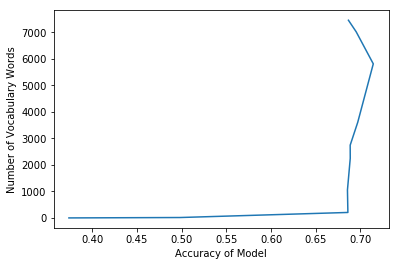

In [49]:
def P6():
    # Keep this random seed here to make comparison easier.
    np.random.seed(0)

    ### STUDENT START ###
    vector = CountVectorizer()
    vector_train_data = vector.fit_transform(train_data)
    vector_dev_data = vector.transform(dev_data)
    
    l1_lr_model = LogisticRegression(penalty = "l1")
    l2_lr_model = LogisticRegression(penalty = "l2")
    l1_lr_model_train = l1_lr_model.fit(vector_train_data, train_labels)
    l2_lr_model_train = l2_lr_model.fit(vector_train_data, train_labels)
    
    print("Number of weights that are not zero for L1 penalty:", np.count_nonzero(l1_lr_model_train.coef_))
    print("Number of weights that are not zero for L2 penalty:", np.count_nonzero(l2_lr_model_train.coef_))

    c_values = [0.001, 0.01, 0.1, 1, 5, 10, 20, 50, 75, 100]
    accuracy = []
    vocab_size = []
    
    for c in c_values:
        # reduce size of vocabulary using non-zeros from L1 model
        l1_nonzero_lr_model = LogisticRegression(C = c, penalty = "l1", tol = 0.01)
        l1_nonzero_model = l1_nonzero_lr_model.fit(vector_train_data, train_labels)
        l1_nonzero_coef = l1_nonzero_model.coef_
        nonzero_l1_words = np.argwhere(l1_nonzero_coef)
        nonzero_index = np.unique(nonzero_l1_words[:, 1])
        words = vector.get_feature_names()
        word_list = [words[x] for x in nonzero_index]

        # retrain L2 model
        vector_nonzero = CountVectorizer(vocabulary = word_list)
        vector_nonzero_train_data = vector_nonzero.fit_transform(train_data)
        vector_nonzero_dev_data = vector_nonzero.fit_transform(dev_data)

        l2_nonzero_lr_model = LogisticRegression(C = c, penalty = "l2", tol = 0.01)
        l2_nonzero_model = l2_nonzero_lr_model.fit(vector_nonzero_train_data, train_labels)
        l2_nonzero_prediction = l2_nonzero_model.predict(vector_nonzero_dev_data)
        l2_nonzero_f1_score = metrics.f1_score(l2_nonzero_prediction, dev_labels, average = "weighted")
        accuracy.append(l2_nonzero_f1_score)
        vocab_size.append(len(word_list))
        
    # Make a plot showing pruned l2 model accuracy vs vocabulary size
    plt.plot(accuracy, vocab_size)
    plt.ylabel("Number of Vocabulary Words")
    plt.xlabel("Accuracy of Model")
    plt.show()
    
    ### STUDENT END ###
P6()

(7) Use the TfidfVectorizer -- how is this different from the CountVectorizer? Train a logistic regression model with C=100.

Make predictions on the dev data and show the top 3 documents where the ratio R is largest, where R is:

maximum predicted probability / predicted probability of the correct label

What kinds of mistakes is the model making? Suggest a way to address one particular issue that you see.

In [50]:
def P7():
### STUDENT START ###

    tfidf_vector = TfidfVectorizer()
    tfidf_vector_train_data = tfidf_vector.fit_transform(train_data)
    tfidf_vector_dev_data = tfidf_vector.transform(dev_data)
    
    tfidf_lr = LogisticRegression(C=100)
    tfidf_lr_model = tfidf_lr.fit(tfidf_vector_train_data, train_labels)
    tfidf_lr_prediction = tfidf_lr.predict(tfidf_vector_dev_data)
    print("F1 score from using TfidVectorizer:", 
          round(metrics.f1_score(tfidf_lr_prediction, dev_labels, average = "weighted"),2))

    # make predictions on dev data
    predictions = tfidf_lr.predict_proba(tfidf_vector_dev_data)
    ratio_R = []
    for prediction in range(len(predictions)):
        max_probability = predictions[prediction].max()
        predicted_probability = predictions[prediction, dev_labels[prediction]]
        ratio_R.append(max_probability / predicted_probability)

    top_3 = [(ratio[0], ratio[1]) for ratio in sorted(enumerate(ratio_R), key = lambda k: k[1], reverse = True)][:3]
    
    for index,R in top_3:
        print("\n")
        print("Predicted category:", categories[tfidf_lr_prediction[index]])
        print("Correct category:", categories[dev_labels[index]])
        print("R-ratio is:", round(R,2))
        print("\n")
        print(train_data[index])
    
## STUDENT END ###
P7()

F1 score from using TfidVectorizer: 0.77


Predicted category: talk.religion.misc
Correct category: sci.space
R-ratio is: 929.36


G'day all,

Can anybody point me at a utility which will read/convert/crop/whatnot/
display HDF image files ? I've had a look at the HDF stuff under NCSA 
and it must take an award for odd directory structure, strange storage
approaches and minimalist documentation :-)

Part of the problem is that I want to look at large (5MB+) HDF files and
crop out a section. Ideally I would like a hdftoppm type of utility, from
which I can then use the PBMplus stuff quite merrily. I can convert the cropped
part into another format for viewing/animation.

Otherwise, can someone please explain how to set up the NCSA Visualisation S/W
for HDF (3.2.r5 or 3.3beta) and do the above cropping/etc. This is for
Suns with SunOS 4.1.2.

Any help GREATLY appreciated. Ta muchly !

Cheers,
	Markus

-- 
Markus Buchhorn, Parallel Computing Research Facility
email = markus@octavia.anu.edu

ANSWER:
Count vectorizer gives equal weight to all words. TFIDF vectorizer comes in three parts. Part one is the term frequency (TF). This simply counts the number of occurances of the word. Part two is the inverse document frequency (IDF). This takes the log of the number of documents divided by the number of documents the word appears in. A common word such as "the" would then equal close to zero. Part three multiplies these two numbers to get the final weight. 

A mistake that this model might be making is including common words that may be bringing down the predicted scores. Using stop words could fix this issue. 

(8) EXTRA CREDIT

Try implementing one of your ideas based on your error analysis. Use logistic regression as your underlying model.

In [51]:
def EC():
    # implement top 30 words in the english language as stop words to improve the model
    stop_words = ["the", "be", "to", "of", "and", "a", "in", "that", "have", "I", 
                  "it", "for", "not", "on", "with", "he", "as", "you", "do", "at",
                  "this", "but", "his", "by", "from", "they", "we", "say", "her", "she"]
    
    tfidf_vector = TfidfVectorizer(stop_words = stop_words)
    tfidf_vector_train_data = tfidf_vector.fit_transform(train_data)
    tfidf_vector_dev_data = tfidf_vector.transform(dev_data)
    
    tfidf_lr = LogisticRegression(C=100)
    tfidf_lr_model = tfidf_lr.fit(tfidf_vector_train_data, train_labels)
    tfidf_lr_prediction = tfidf_lr.predict(tfidf_vector_dev_data)
    print("F1 score from using stop words:", 
          round(metrics.f1_score(tfidf_lr_prediction, dev_labels, average = "weighted"),3))
    
    tfidf_vector_orig = TfidfVectorizer()
    tfidf_vector_train_data_orig = tfidf_vector_orig.fit_transform(train_data)
    tfidf_vector_dev_data_orig = tfidf_vector_orig.transform(dev_data)
    
    tfidf_lr_orig = LogisticRegression(C=100)
    tfidf_lr_model_orig = tfidf_lr_orig.fit(tfidf_vector_train_data_orig, train_labels)
    tfidf_lr_prediction_orig = tfidf_lr_orig.predict(tfidf_vector_dev_data_orig)
    print("F1 score from using TfidVectorizer:", 
          round(metrics.f1_score(tfidf_lr_prediction_orig, dev_labels, average = "weighted"),3))
    
EC()

F1 score from using stop words: 0.773
F1 score from using TfidVectorizer: 0.767


It is a slight improvement of 0.6% by using the 30 most common words in the English language as stop words.